In [1]:
import numpy as np
import tensorflow as tf
from tensorflow_core.python.client import device_lib
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

## Setting up GPU stuff:
Making sure that operations are executing on the GPU

In [2]:
print('Devices: {}'.format(device_lib.list_local_devices()))

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9104588147882895127
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3137182107
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11204164250074927848
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Creating data generators for training, validation and testing

In [43]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    )

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

ERROR! Session/line number was not unique in database. History logging moved to new session 68


## Loading train, validation and test images from the FER-2013 Kaggle dataset

In [44]:
train_dataset  = train_datagen.flow_from_directory(directory = './train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [45]:
valid_dataset = valid_datagen.flow_from_directory(directory = './train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [46]:
test_dataset = test_datagen.flow_from_directory(directory = './test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
ERROR! Session/line number was not unique in database. History logging moved to new session 72


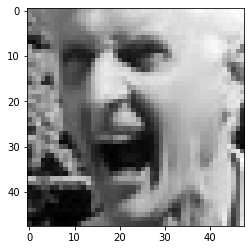

In [57]:
# Displaying one of the test images
from keras.preprocessing import image

img = image.load_img('D:/Documents/Courses/Projects/Facial Emotion Recognition/test/angry/PrivateTest_1109992.jpg', target_size=(48, 48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

## Base Model:
Downloading ResNet50 from keras

In [48]:
base_model = ResNet50(input_shape=(48, 48, 3),
                    include_top=False,  # include_top=False means that the classification layer is no longer present
                    weights='imagenet')

In [40]:
def fer_model(base_model, input_shape):

    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # declaring the input
    inputs = Input(shape=input_shape)

    # obtaining image embeddings from the second last layer
    x = base_model(inputs, training=False)

    # adding global avg pooling
    x = GlobalAvgPool2D()(x)

    # including dropout with prob=0.2
    x = Dropout(rate=0.2)(x)

    # adding the prediction layer with 7 units, softmax activation
    prediction_layer = Dense(units=7, activation='softmax')(x)

    # outputs
    outputs = prediction_layer

    model = Model(inputs, outputs)

    return model

In [41]:
fer_model_1 = fer_model(base_model, input_shape=(48, 48, 3))
fer_model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
# Training the non-fine tuned fer_net:

base_learning_rate = 0.01
metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
            ]


fer_model_1.compile(
                    optimizer=Adam(lr=base_learning_rate),
                    loss='categorical_crossentropy',
                    metrics=metrics
                    )

check_point = ModelCheckpoint('fer_net_1.h5')
early_stopping = EarlyStopping(verbose=1, patience=5)

In [ ]:
history = fer_model_1.fit(train_dataset, validation_data=valid_dataset, epochs=20, verbose=1, callbacks=[check_point, early_stopping])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\IntroToML-Homeworks\ipykernel_8564\4041603403.py", line 1, in <module>
    history = fer_model_1.fit(train_dataset, validation_data=valid_dataset, epochs=20, verbose=1, callbacks=[check_point, early_stopping])
  File "C:\Anaconda\envs\deeplearning\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Anaconda\envs\deeplearning\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 235, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Anaconda\envs\deeplearning\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 593, in _process_training_inputs
    use_multiprocessing=use_multiprocessing)
  File "C:\Anaconda\envs\deeplearning\lib\sit

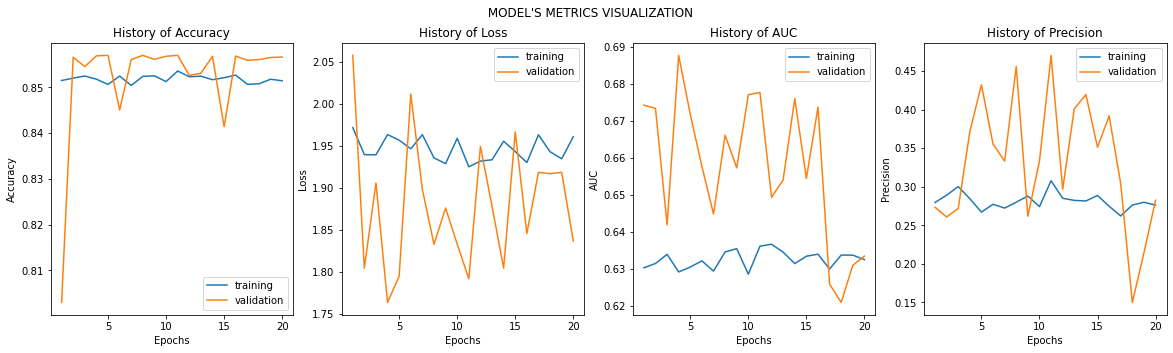

In [15]:
# Plotting Results for model without fine-tuning

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    plt.show()


Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision']
               )

## Fine-tuning the model by unfreezing some layers and letting it learn:

In [49]:
base_model.trainable = True
print('Number of layers in the model: {}'.format(len(base_model.layers)))
print(base_model.layers[155])

base_model.summary()

Number of layers in the model: 175
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
________________________________________________________

In [50]:
def fer_model_fine_tune(base_model, input_shape):
    fine_tune_start = 155

    # Freezing all layers before the fine_tune_start layer
    for layer in base_model.layers[: fine_tune_start]:
        layer.trainable = None

    # declaring the input
    inputs = Input(shape=input_shape)

    # obtaining image embeddings from the second last layer
    x = base_model(inputs, training=False)

    # adding global avg pooling
    x = GlobalAvgPool2D()(x)

    # including dropout with prob=0.2
    x = Dropout(rate=0.2)(x)

    # adding a flatten layer
    x = Flatten()(x)

    # adding the prediction layer with 7 units, softmax activation
    prediction_layer = Dense(units=7, activation='softmax')(x)

    # outputs
    outputs = prediction_layer

    model = Model(inputs, outputs)

    return model

In [51]:
fer_model_2 = fer_model_fine_tune(base_model, input_shape=(48, 48, 3))
fer_model_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 8,945,671
Non-trainable params: 14,656,384
_______________________________________

In [52]:
# Training the non-fine tuned fer_net:
base_learning_rate = 0.01
metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
            ]


fer_model_2.compile(
                    optimizer=Adam(lr=base_learning_rate * 0.1),
                    loss='categorical_crossentropy',
                    metrics=metrics
                    )

check_point = ModelCheckpoint('fer_net_2.h5')
early_stopping = EarlyStopping(verbose=1, patience=5)

In [54]:
history_fine = fer_model_2.fit(train_dataset, validation_data=valid_dataset, epochs=20, verbose=1, callbacks=[check_point, early_stopping])

ERROR! Session/line number was not unique in database. History logging moved to new session 70
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 359 steps, validate for 90 steps
Epoch 1/20
359/359 [==============================] - 87s 242ms/step - loss: 1.7196 - accuracy: 0.8576 - precision: 0.5491 - recall: 0.0182 - auc: 0.7083 - val_loss: 1.7623 - val_accuracy: 0.8577 - val_precision: 0.5870 - val_recall: 0.0141 - val_auc: 0.6948
Epoch 2/20
359/359 [==============================] - 87s 242ms/step - loss: 1.7163 - accuracy: 0.8580 - precision: 0.5751 - recall: 0.0242 - auc: 0.7100 - val_loss: 1.7390 - val_accuracy: 0.8576 - val_precision: 0.6462 - val_recall: 0.0073 - val_auc: 0.7027
Epoch 3/20
359/359 [==============================] - 89s 248ms/step - loss: 1.7026 - accuracy: 0.8584 - precision: 0.5779 - recall: 0.0317 - auc: 0.7174 - val_loss: 1.6799 - val_accuracy: 0.8587 - val_precision: 0.6189 - val_recall: 0.0286 - val_auc: 0.7301
Epoch 4/20
359/359 [==============================] - 89s 248ms/step - loss: 1.6910 - accuracy: 0.8589 - precision: 0.5916 - recall: 0.0394 - auc: 0.7220 - val_loss: 1.6987 - val_a

## Evaluating fine-tuned model's performance:

In [55]:
loss, accuracy, precision, recall, auc = fer_model_2.evaluate(test_dataset)
print('Accuracy: {}'.format(accuracy))

  ...
    to  
  ['...']


  ...
    to  
  ['...']


113/113 [==============================] - 20s 176ms/step - loss: 1.6389 - accuracy: 0.8633 - precision: 0.6699 - recall: 0.0854 - auc: 0.7451
Accuracy: 0.8633323907852173


In [56]:
def freeze(model):
    for layer in model.layers:
        layer.trainable = True

        if isinstance(layer, Model):
            freeze(layer)

freeze(fer_model_2)
fer_model_2.save_weights('ferNet.h5')

ERROR! Session/line number was not unique in database. History logging moved to new session 75
Emotion detected: Happy


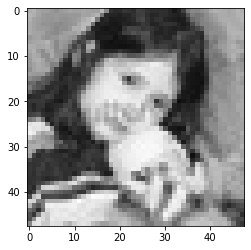

In [62]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

img = image.load_img('D:/Documents/Courses/Projects/Facial Emotion Recognition/test/sad/PrivateTest_366361.jpg')
img = np.array(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
predictions = fer_model_2.predict(img)

print('Emotion detected: {}'.format(emotion_dict[np.argmax(predictions)]))